In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [204]:
# load the data
train_ds = np.load('train_data.npz')
val_ds = np.load('val_data.npz')
test_ds = np.load('test_data.npz')

In [205]:
print(train_ds.files)
print(val_ds.files)
print(test_ds.files)

['imgs', 'labels']
['imgs', 'labels']
['imgs']


In [206]:
print("Shape of train_ds images:", train_ds['imgs'].shape)  
print("Shape of train_ds labels:", train_ds['labels'].shape)
print("Shape of val_ds images:", val_ds['imgs'].shape)  
print("Shape of val_ds labels:", val_ds['labels'].shape)
print("Shape of test_ds images:", test_ds['imgs'].shape)  

Shape of train_ds images: (4708, 28, 28)
Shape of train_ds labels: (4708, 1)
Shape of val_ds images: (524, 28, 28)
Shape of val_ds labels: (524, 1)
Shape of test_ds images: (624, 28, 28)


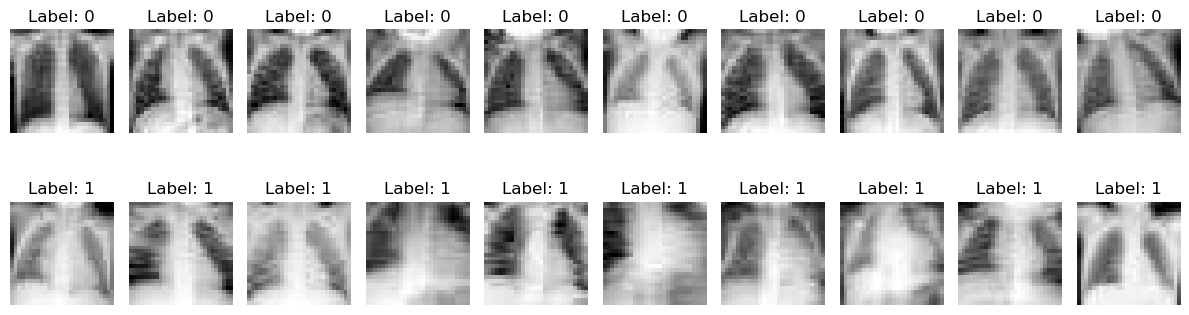

In [207]:
num_samples = 10
sample_zero_indexes = np.where(train_ds['labels'] == 0)[0][:num_samples]
sample_one_indexes = np.where(train_ds['labels'] == 1)[0][:num_samples]

fig, axes = plt.subplots(2, num_samples, figsize=(12, 4)) # Adjust figsize as needed

for index_0, index_1 in zip(sample_zero_indexes, sample_one_indexes):
    axes[0, np.where(sample_zero_indexes == index_0)[0][0]].imshow(train_ds['imgs'][index_0], cmap='gray')
    axes[0, np.where(sample_zero_indexes == index_0)[0][0]].axis('off')
    axes[0, np.where(sample_zero_indexes == index_0)[0][0]].set_title('Label: 0')

    axes[1, np.where(sample_one_indexes == index_1)[0][0]].imshow(train_ds['imgs'][index_1], cmap='gray')
    axes[1, np.where(sample_one_indexes == index_1)[0][0]].axis('off')
    axes[1, np.where(sample_one_indexes == index_1)[0][0]].set_title('Label: 1')

plt.tight_layout()
plt.show()

In [208]:
def compute_covariance_matrix(X, mean=None):
    X = X.reshape(X.shape[0], -1)  
    if mean is None:
        mean = np.mean(X, axis=0)
    X_centered = X - mean
    return np.cov(X_centered, rowvar=False), mean

In [209]:
def perform_pca(X, num_components):
    covariance_matrix, mean = compute_covariance_matrix(X)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    selected_eigenvectors = sorted_eigenvectors[:, :num_components]
    X_centered = X.reshape(X.shape[0], -1) - np.mean(X.reshape(X.shape[0], -1), axis=0)
    X_reduced = np.dot(X_centered, selected_eigenvectors)
    return X_reduced, selected_eigenvectors, sorted_eigenvalues[:num_components], mean

In [210]:
def pca_transform(X, mean, components):
    X = X.reshape(X.shape[0], -1)
    X_centered = X - mean
    return np.dot(X_centered, components)


In [213]:
total_variance = np.sum(compute_covariance_matrix(train_ds['imgs'])[0].diagonal())
explained_variances = []
desired = 0.95
num_components=1
explained_variance = 0
while explained_variance < desired:
    _, _, eigenvalues,_ = perform_pca(train_ds['imgs'], num_components)
    explained_variance = np.sum(eigenvalues) / total_variance
    explained_variances.append(explained_variance)
    num_components += 1


In [214]:
num_components_list = list(range(1, len(explained_variances) + 1))
print(f"Number of components to explain at least {desired*100}% variance: {num_components - 1}")
percentage_explained_variances = [var * 100 for var in explained_variances]


Number of components to explain at least 95.0% variance: 71


In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(num_components_list, percentage_explained_variances, marker='o')
plt.title('Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('% Explained Variance')
# plt.xticks(num_components_list)
plt.grid()
plt.show()

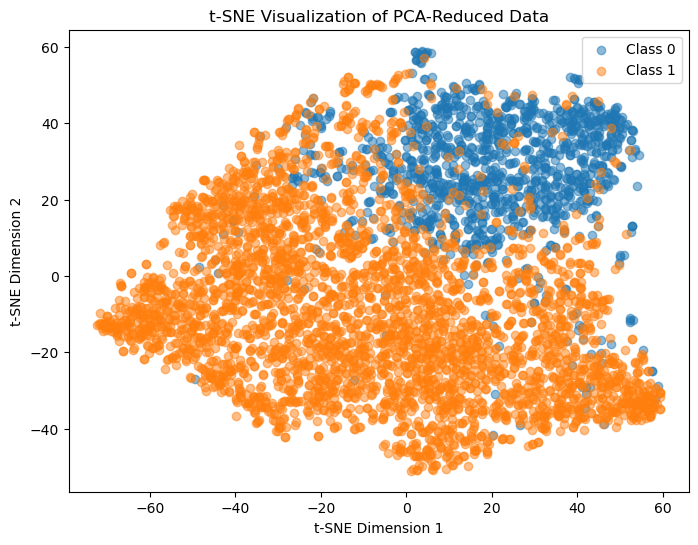

In [223]:
X_reduced_train, comps, eigvals, mean = perform_pca(train_ds['imgs'], 71)
train_labels = train_ds['labels'].ravel()   # shape becomes (4708,)
# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_train_tsne = tsne.fit_transform(X_reduced_train)
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[train_labels == 0, 0], X_train_tsne[train_labels == 0, 1], label='Class 0', alpha=0.5)
plt.scatter(X_train_tsne[train_labels == 1, 0], X_train_tsne[train_labels == 1, 1], label='Class 1', alpha=0.5)
plt.title('t-SNE Visualization of PCA-Reduced Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()


In [220]:
X_reduced_val = pca_transform(val_ds['imgs'], mean, comps)
X_reduced_test = pca_transform(test_ds['imgs'], mean, comps)

In [221]:
X_reduced_val_tsne = tsne.fit_transform(X_reduced_val)
X_reduced_test_tsne = tsne.fit_transform(X_reduced_test)

In [ ]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

In [ ]:
def predict(data,w,b):
    z = np.dot(data,w)+b 
    return (sigmoid(z)>=0.5).astype(int)

In [238]:
def logistic_regression(train_data, train_labels,val_data,val_labels, lr, epochs, patience, lambda_reg=0.001):
    train_labels = train_labels.ravel()
    val_labels = val_labels.ravel()
    n_sample, n_feature = train_data.shape
    w = np.zeros(n_feature)
    b = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float("inf")
    best_w, best_b = None, None
    patience_counter = 0
    for t in range(1,epochs+1):
        z = np.dot(train_data,w)+b
        y_pred = sigmoid(z)
        loss = -(np.dot(train_labels, np.log(y_pred + 1e-5)) + np.dot((1 - train_labels), np.log(1 - y_pred + 1e-5))) / n_sample
        train_losses.append(loss)
        y_class = (y_pred>=0.5).astype(int)
        accuracy = (y_class==train_labels).mean()
        train_accuracies.append(accuracy)
        
        z_val = np.dot(val_data, w) + b
        y_val = sigmoid(z_val)
        y_val_class = (y_val>=0.5).astype(int) 
        acc =  (y_val_class==val_labels).mean()
        val_loss = -(np.dot(val_labels, np.log(y_val + 1e-5)) + np.dot((1 - val_labels), np.log(1 - y_val + 1e-5))) / len(val_labels)
        val_losses.append(val_loss)
        if t%5==0:
            print(f"Trainig accuracy at epoch {t} is {accuracy*100:.2f}%, Validation accuracy is {acc*100:.2f} ")
        val_accuracies.append(acc)
        dw = (1/n_sample) *np.dot(train_data.T, (y_pred-train_labels))+lambda_reg * w
        db = (1/n_sample) *np.sum(y_pred-train_labels)
        
        w -= lr*dw
        b -= lr*db
        
        if val_loss<best_val_loss-1e-06:
            best_val_loss=val_loss
            best_w, best_b = w.copy(), b
            patience_counter=0
        else:
            patience_counter+=1
            if patience_counter>patience:
                print(f"Early stopping at epoch {t}")
                break
    return w,b, train_losses, val_losses, train_accuracies, val_accuracies

In [239]:
w, b, train_losses, val_losses, train_acc, val_acc = logistic_regression(
    X_train_tsne, train_ds['labels'],
    X_reduced_val_tsne, val_ds['labels'],
    lr=0.01, epochs=1000, patience=15)


Trainig accuracy at epoch 5 is 80.01%, Validation accuracy is 35.50 
Trainig accuracy at epoch 10 is 80.16%, Validation accuracy is 36.07 
Trainig accuracy at epoch 15 is 80.35%, Validation accuracy is 36.45 
Early stopping at epoch 17


In [240]:
train_acc = [ac*100 for ac in train_acc]
val_acc = [ac*100 for ac in val_acc]

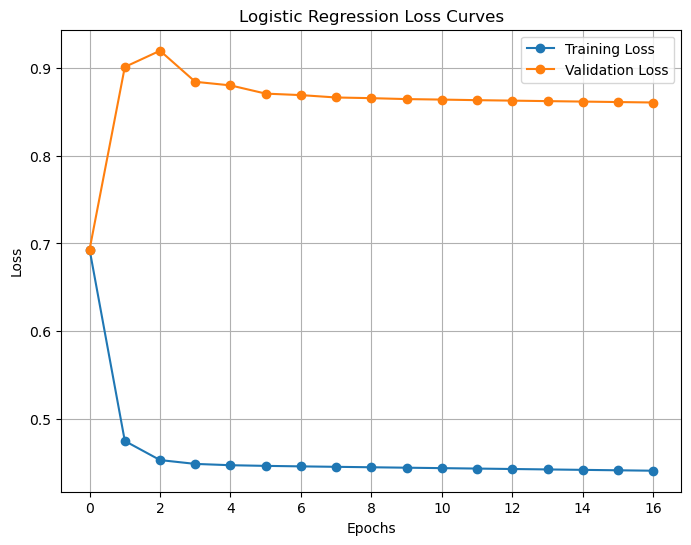

In [237]:
plt.figure(figsize=(8,6))
plt.plot(train_losses,marker = 'o', label="Training Loss")
plt.plot(val_losses, marker = 'o',label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Logistic Regression Loss Curves")
plt.legend()
plt.grid(True)
plt.show()


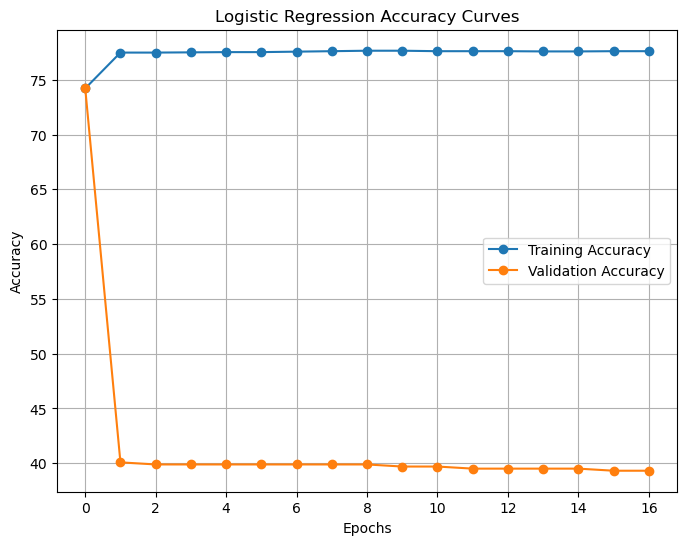

In [227]:
plt.figure(figsize=(8,6))
plt.plot(train_acc, marker = 'o', label="Training Accuracy")
plt.plot(val_acc,marker = 'o', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_test_pred = predict(X_reduced_test_tsne, w, b)

array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,